##### 1차적 전처리(결측지 해결)를 마쳤습니다.

0. EDA 를 통해 새로운 Feature 를 탐색해볼 계획입니다.
1. SVC 모델에 맞게 모든 변수를 MinMaxScaler/dummy 를 이용해 모든 변수를 0 과 1 사이의 값으로 변경해줄 것입니다.
2. 이상치를 해결하여 더 효율적으로 MinMaxScaler 를 실행하겠습니다.   

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

train = pd.read_csv('adjtrain.csv')
test = pd.read_csv('adjtest.csv')

In [156]:
train_and_test = [train, test]

In [157]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Cabin_Ex
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,0


#### 감각적 선택과 상관관계를 통한 feature 선택

1. 저는 타이타닉 데이터 셋의 features를 탑승자 고유의 정보와 배에 대한 정보로 나누겠습니다.

- 탑승자 고유 정보 : Sex, Age, SibSp, Parch, Embarked, Title
- 배에 대한 정보 : Pclass, Fare, Cabin_Ex
- 위에 해당되지 않은 feature는 drop할 예정입니다.

3. 탑승자 정보 : Sex 는 성별, Age 는 나이, SibSp, Parch 는 동승자, Embarked 는 탑승지를 확인할 수 있고 Title을 통해서는 나이, 성별과 혼인 유무를 추론할 수 있습니다.
4. 배 정보 : 결국 배에 대한 정보는 Fare 에 영향을 크게 받을것이라고 예상합니다.
5. 강력한 상관관계를 가지진 않아 모두 활용하겠습니다. Fare&Pclass corr : -0.54, Fare&Cabin_Ex corr : 0.48, Pclass&Cabin_Ex : 0.30

In [158]:
from sklearn.metrics import matthews_corrcoef
print("phi corr : ",round(matthews_corrcoef(train['Survived'],train['Cabin_Ex']), 4))

phi corr :  0.3169


In [159]:
stats.pointbiserialr(train['Fare'], train['Pclass'])

PointbiserialrResult(correlation=-0.5644403668640445, pvalue=4.206904825492999e-76)

In [160]:
stats.pointbiserialr(train['Fare'], train['Cabin_Ex'])

PointbiserialrResult(correlation=0.4883048054784012, pvalue=1.426314553257025e-54)

In [161]:
matthews_corrcoef(train['Pclass'], train['Cabin_Ex'])

0.3098934154545896

In [162]:
for dataset in train_and_test:
    dataset['Sex'] = dataset['Sex'].replace('male', 0)
    dataset['Sex'] = dataset['Sex'].replace('female', 1)

In [174]:
for dataset in train_and_test:
    dataset['Title'] = dataset['Title'].replace(['Miss','Mrs','Master'], 'Baby&male')

In [175]:
for dataset in train_and_test:
    dataset['Family'] = dataset['SibSp'] + dataset['Parch']

#### feature 간 상관관계 확인

* 주의 : feature's type 에 맞춰 상관관계를 계산해야 더 정확합니다.
* corr() 의 경우 default = pearson 입니다.

#### Feature Choice /

1. Sex, Cabin_Ex 이대로 사용
2. Title, Pclass dummy 를 통한 on-hot encoding 
3. Age 범주화 > dummy
4. SibSp, Parch 합쳐서 Family 로 사용하려 했으나 일단 보류 

In [176]:
train.corr()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin_Ex,Family
PassengerId,1.000000,-0.005007,-0.035144,-0.042939,0.042675,-0.057527,-0.001652,0.021055,0.019919,-0.040143
Survived,-0.005007,1.000000,-0.338481,0.543351,-0.089115,-0.035322,0.081629,0.247268,0.316912,0.016639
Pclass,-0.035144,-0.338481,1.000000,-0.131900,-0.343645,0.083081,0.018443,-0.564440,-0.725541,0.065997
Sex,-0.042939,0.543351,-0.131900,1.000000,-0.117218,0.114631,0.245489,0.172352,0.140391,0.200988
Age,0.042675,-0.089115,-0.343645,-0.117218,1.000000,-0.267627,-0.196809,0.096610,0.235442,-0.281236
SibSp,-0.057527,-0.035322,0.083081,0.114631,-0.267627,1.000000,0.414838,0.153234,-0.040460,0.890712
Parch,-0.001652,0.081629,0.018443,0.245489,-0.196809,0.414838,1.000000,0.209823,0.036987,0.783111
Fare,0.021055,0.247268,-0.564440,0.172352,0.096610,0.153234,0.209823,1.000000,0.488305,0.209554
Cabin_Ex,0.019919,0.316912,-0.725541,0.140391,0.235442,-0.040460,0.036987,0.488305,1.000000,-0.009175
Family,-0.040143,0.016639,0.065997,0.200988,-0.281236,0.890712,0.783111,0.209554,-0.009175,1.000000


In [177]:
Q1 = train['Age'].quantile(.25)
Q3 = train['Age'].quantile(.75)
IQR = round(Q3 - Q1, 2)
print("Q1 : ", Q1 , "Q3 : ", Q3, "IQR : ", IQR)

Q1 :  21.81 Q3 :  35.89 IQR :  14.08


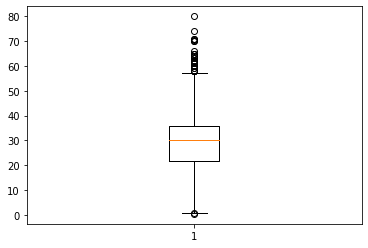

In [178]:
plt.boxplot(train['Age'])
plt.show()

In [179]:
def age_category(age):
    cat = ''
    if age < 7 : cat = 'B'
    elif age < 18 : cat = 'T'
    elif age < Q3 + 1.5*IQR : cat = 'O'
    else: cat = 'VO'

    return cat


In [180]:
for dataset in train_and_test:
    dataset['Age_Band'] = dataset['Age'].apply(lambda x :age_category(x))

In [181]:
pd.crosstab(train['Age_Band'],train['Survived'])

Survived,0,1
Age_Band,,
B,16,35
O,472,269
T,38,28
VO,23,10


In [182]:
grouped = train['Survived'].groupby(train['Age_Band'])

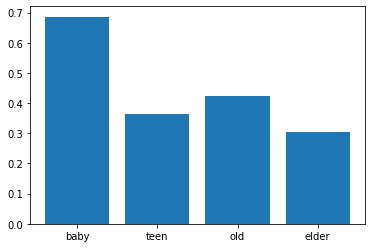

In [183]:
x = ['baby','teen','old','elder']
y = grouped.sum()/grouped.size()

plt.bar(x,y)
plt.show()

In [184]:
train.to_csv('adjtrain2.csv', index = False)
test.to_csv('adjtest2.csv',index = False)